# DiploDatos 2020 - Coronavirus en Argentina

El dataset se encuetra en:

https://github.com/lucia15/Datos-Covid19-Argentina

In [51]:
### Aumentar el ancho del notebook
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

## Práctico Introducción al Machine Learning

**Consigna:**

Proponer un modelo de Aprendizaje Automático para estos datos. 

Para ello deberan explorar y probar varios modelos, buscando las configuraciones que mejores resultados den. Tener en cuenta:

* Elección de la variable objetivo y features
* Selección de un modelo
* Ajuste de hiperparámetros 
* Evaluación

Veamos unos sencillos (e incompletos) **ejemplos**.

### Carga de datos

In [52]:
# Importamos librerías necesarias

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [53]:
url = 'https://raw.githubusercontent.com/lucia15/Datos-Covid19-Argentina/master/Argentina-covid19.csv'

data = pd.read_csv(url, error_bad_lines=False)

**Variable objetivo: 'casos_nuevos'**

Puesto que muchas de las variables presentes en el dataset son **series temporales**, es importante tener en cuenta que para aplicar modelos de aprendizaje supervisado, es necesario realizar algunas adaptaciones previamente.

El siguiente método se conoce como **sliding window**.

In [54]:
df = pd.DataFrame()

df['t'] = data['casos_nuevos']
df['t+1'] =  df['t'].shift(-1)

df

,t,t+1
0,1,1.0
1,1,7.0
2,7,3.0
3,3,5.0
4,5,2.0
...,...,...
170,7759,5352.0
171,5352,8713.0
172,8713,8771.0
173,8771,10550.0


Tiramos la última fila que contiene un NaN

In [55]:
df.drop(df.tail(1).index,inplace=True)

In [56]:
df['t'].shape, df['t+1'].shape

((174,), (174,))

Fuente: https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/

### División en etrenamiento y evaluación

In [57]:
from sklearn.model_selection import train_test_split

In [58]:
X, y = df['t'].to_numpy().reshape(-1,1), df['t+1'].to_numpy().reshape(-1,1)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=0)
X_train.shape, X_test.shape

((139, 1), (35, 1))

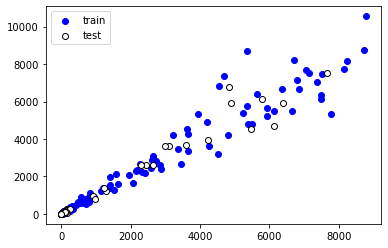

In [59]:
plt.scatter(X_train, y_train, color="blue", label="train")
plt.scatter(X_test, y_test, color="white", edgecolor="k", label="test")
plt.legend()
plt.show()

### Regresión Lineal

Probaremos ajustar los puntos usando una recta.

In [60]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

In [61]:
# Create linear regression object
regr = linear_model.LinearRegression()

In [62]:
# Train the model using the training sets
regr.fit(X_train, y_train)

# Make predictions using the testing set
y_test_pred = regr.predict(X_test)

# and training set
y_train_pred = regr.predict(X_train)

In [63]:
# The coefficients
print('Coefficients: \n', regr.coef_)

# The mean squared error
train_error = mean_squared_error(y_train, y_train_pred)
test_error = mean_squared_error(y_test, y_test_pred)

print('Mean squared error')

print('Train error: %.2f' % train_error)
print('Test error: %.2f' % test_error)

# The coefficient of determination: 1 is perfect prediction

train_coeff = r2_score(y_train, y_train_pred)
test_coeff = r2_score(y_test, y_test_pred)

print('Coefficient of determination')

print('Train: %.2f' % train_coeff)
print('Test: %.2f' % test_coeff)

Coefficients: 
 [[1.00407423]]
Mean squared error
Train error: 379151.02
Test error: 263411.56
Coefficient of determination
Train: 0.95
Test: 0.95


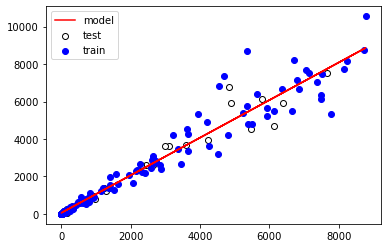

In [64]:
# Plot outputs
plt.scatter(X_test, y_test,  color='white', edgecolor='k', label='test')
plt.scatter(X_train, y_train,  color='blue', label='train')
plt.plot(X_train, y_train_pred, color='red', label='model')
plt.legend()
plt.show()

### Clasificación

In [128]:
url = 'https://raw.githubusercontent.com/lucia15/Datos-Covid19-Argentina/master/Argentina-covid19-fallecidos.csv'

data = pd.read_csv(url, error_bad_lines=False)

In [129]:
data = data.drop(columns=['fecha', 'num_caso', 'tipo_caso', 'comorbilidades', 'viajes', 'observaciones'])

data = data.dropna()

data

,provincia,genero,edad
0,CABA,hombre,64.0
1,Chaco,hombre,61.0
2,CABA,hombre,64.0
3,Buenos Aires,mujer,67.0
5,Chaco,hombre,53.0
...,...,...,...
2277,Río Negro,hombre,87.0
2278,Buenos Aires,mujer,74.0
2279,Buenos Aires,mujer,61.0
2280,Buenos Aires,mujer,64.0


In [130]:
criteria = [data['edad'].between(0, 30), data['edad'].between(31, 60), data['edad'].between(61, 80), data['edad'].between(81, 100)]
values = ['0-30', '31-60', '61-80', '81-100']


In [131]:
data['rango-edad'] = np.select(criteria, values, 0)

In [132]:
data = data.drop(['edad'], axis=1)

### Tratamiento de género y rango-edad
Como se trata de **variables categóricas**, en la cuál no hay una relación de orden entre las categorías, necesitamos aplicar un **One Hot Encoding**

In [133]:
data = pd.concat([data, pd.get_dummies(data['genero'], prefix='genero')],axis=1).drop(['genero'], axis=1)

In [134]:
data = pd.concat([data, pd.get_dummies(data['rango-edad'], prefix='rango-edad')],axis=1).drop(['rango-edad'], axis=1)

In [136]:
data

,provincia,genero_hombre,genero_mujer,rango-edad_0,rango-edad_0-30,rango-edad_31-60,rango-edad_61-80,rango-edad_81-100
0,CABA,1,0,0,0,0,1,0
1,Chaco,1,0,0,0,0,1,0
2,CABA,1,0,0,0,0,1,0
3,Buenos Aires,0,1,0,0,0,1,0
5,Chaco,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...
2277,Río Negro,1,0,0,0,0,0,1
2278,Buenos Aires,0,1,0,0,0,1,0
2279,Buenos Aires,0,1,0,0,0,1,0
2280,Buenos Aires,0,1,0,0,0,1,0


### Selección de features y variable objetivo

**variable objetivo: 'provincia'**

In [143]:
feature_names = ['genero_hombre', 'genero_mujer']

X = data[feature_names]
y = data['provincia']

In [144]:
X.shape, y.shape

((2254, 2), (2254,))

### División en etrenamiento y evaluación

In [145]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [146]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1690, 2), (564, 2), (1690,), (564,))

### Logistic Regression

In [147]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()

logreg.fit(X_train, y_train)

print('Accuracy of Logistic regression classifier on training set: {:.2f}'.format(logreg.score(X_train, y_train)))
print('Accuracy of Logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of Logistic regression classifier on training set: 0.50
Accuracy of Logistic regression classifier on test set: 0.49


In [76]:
from sklearn.metrics import classification_report

y_train_pred = logreg.predict(X_train)
y_test_pred = logreg.predict(X_test)

print(classification_report(y_test, y_test_pred))

precision    recall  f1-score   support

         2.0       0.00      0.00      0.00       2.0
         3.0       0.00      0.00      0.00       1.0
        11.0       0.00      0.00      0.00       1.0
        66.0       0.00      0.00      0.00       1.0
        79.0       0.00      0.00      0.00       1.0
        80.0       0.00      0.00      0.00       1.0
        86.0       0.00      0.00      0.00       1.0
        90.0       0.00      0.00      0.00       1.0
       102.0       0.00      0.00      0.00       1.0
       103.0       0.00      0.00      0.00       1.0
       105.0       0.00      0.00      0.00       1.0
       112.0       0.00      0.00      0.00       1.0
       134.0       0.00      0.00      0.00       1.0
       143.0       0.00      0.00      0.00       1.0
       146.0       0.00      0.00      0.00       1.0
       158.0       0.00      0.00      0.00       1.0
       188.0       0.00      0.00      0.00       1.0
       240.0       0.00      0.00      0.

In [142]:
data

,provincia,genero_hombre,genero_mujer,rango-edad_0,rango-edad_0-30,rango-edad_31-60,rango-edad_61-80,rango-edad_81-100
0,CABA,1,0,0,0,0,1,0
1,Chaco,1,0,0,0,0,1,0
2,CABA,1,0,0,0,0,1,0
3,Buenos Aires,0,1,0,0,0,1,0
5,Chaco,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...
2277,Río Negro,1,0,0,0,0,0,1
2278,Buenos Aires,0,1,0,0,0,1,0
2279,Buenos Aires,0,1,0,0,0,1,0
2280,Buenos Aires,0,1,0,0,0,1,0
